<a href="https://colab.research.google.com/github/TarekQMUL/ECS7022P_Poetry_Generation/blob/main/ECS7022P_170431981_CODE_COMPLETE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code developed by Tarek Ahmed QMUL for Module Computational Creativity ECS7022P

Final project Code developed from resources such as RNN lab 3, Allison Parish Tutorial, Text Generation Shakespere by Oleksii Trekhleb and knowledge from research Links to source below:



In [ ]:
#@title Imports

import tensorflow as tf
import numpy as np
import random
import os
import gzip, json
import pandas as pd
import csv
from keras import regularizers
import keras.utils as ku 
from keras.layers import Activation
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.models import Sequential
!pip install pronouncing
import pronouncing
import string
from collections import defaultdict
import re, os

     |████████████████████████████████| 939 kB 37.8 MB/s 
  Created wheel for pronouncing: filename=pronouncing-0.2.0-py2.py3-none-any.whl size=6252 sha256=d2e29cd12948850c02442b7f7c64961fde800fd0665223435b8c1a2e7607500e
  Stored in directory: /root/.cache/pip/wheels/09/e8/c0/3606d42fdbf5f3871564eb6a353591a8f5deeed013fdb73921
Successfully built pronouncing


In [ ]:
device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))

print(tf.__version__)
!nvidia-smi -L

Found GPU at: /device:GPU:0
2.8.0
GPU 0: Tesla T4 (UUID: GPU-2da5588c-c52f-7af0-22a6-25244a3ebee7)


In [ ]:
#@title Save checkpoints during training

from google.colab import drive
drive.mount('/content/gdrive')

# Directory where the checkpoints will be saved
path = 'My Drive/ECS7022P_FINAL_PROJECT/ECS7022P-checkpoints/' #@param{type: 'string'}
full_path = "/content/gdrive/" + path + "ckpt_{epoch}" 

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                      filepath=full_path,
                      save_weights_only=True)

Mounted at /content/gdrive


Retrive The Dataset

In [ ]:
# Reference Allison Parrish 
!curl -O http://static.decontextualize.com/gutenberg-poetry-v001.ndjson.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 52.2M  100 52.2M    0     0  81.3M      0 --:--:-- --:--:-- --:--:-- 81.2M


Place data into a List

In [ ]:
# Reference Allison Parrish
all_dataset_lines = []
for line in gzip.open("gutenberg-poetry-v001.ndjson.gz"):
    all_dataset_lines.append(json.loads(line.strip()))

Create Dictionary of Rhyming sentences

In [ ]:
# Reference Allison Parrish
by_rhyming_part = defaultdict(lambda: defaultdict(list))
for line in all_dataset_lines:
    text = line['s']
    if not(32 < len(text) < 48): # only use lines of uniform lengths
        continue
    match = re.search(r'(\b\w+\b)\W*$', text)
    if match:
        last_word = match.group()
        pronunciations = pronouncing.phones_for_word(last_word)
        if len(pronunciations) > 0:
            rhyming_part = pronouncing.rhyming_part(pronunciations[0])
            # group by rhyming phones (for rhymes) and words (to avoid duplicate words)
            by_rhyming_part[rhyming_part][last_word.lower()].append(text)

Group the rhyming data

In [ ]:
# reference Allison Parrish
rhyme_groups = [group for group in by_rhyming_part.values() if len(group) >= 2]

Create rhyming couplets

In [ ]:
# reference Modified Allison parish
Num_of_lines = 20000#@param{type: "integer"}
feed_data = int(Num_of_lines/2)
fulldata = []
for i in range(feed_data):
    group = random.choice(rhyme_groups)
    words = random.sample(list(group.keys()), 2)
    setA = random.choice(group[words[0]])
    setB = random.choice(group[words[1]])
    
    datasetTest = setA + "\n" + setB
    fulldata.append(datasetTest)

#print(fulldata)


Save Dataset to CSV

In [ ]:
dataset_poems = pd.DataFrame(fulldata)

dataset_path = 'My Drive/ECS7022P_FINAL_PROJECT/' #@param{type: 'string'}
full_dataset_path = "/content/gdrive/"  + dataset_path + "dataset.csv"

dataset_poems.to_csv(full_dataset_path, index=False,header=False)
print("Dataset saved to drive \n")
dataset_poems.to_csv('dataset.csv', index=False,header=False)
print("Dataset saved to runtime \n")

print("Number of lines present:-", 
      len(dataset_poems) * 2)

Dataset saved to drive 

Dataset saved to runtime 

Number of lines present:- 20000


Load Dataset from CSV;

If running for the first time set preload_dataset to false
If running from pretrained model set preload_dataset to true

Note to examiner: when using pretrained model it may not allow you to use the path provided as it is saved to my google drive, i have linked the folder so you can copy the model checkpoint and dataset to your drive to run the project.

In [ ]:
preload_dataset = False #@param ["False","True"]{type:"raw"}
if preload_dataset == True:
  path_to_file = full_dataset_path
  print("Using Preloaded dataset \n")
else:
  path_to_file = 'dataset.csv'
  print("Using runtime dataset \n")

path_to_file = 'dataset.csv'
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
text = text.lower()
text = text.replace('"', " ")
text = text.replace('(', " ")
text = text.replace(')', " ")
text = text.replace('!', "")
text = text.replace('?', "")
#text = text.replace('\n', ":")
text = text.replace('  ', " ")
text = text.replace('y^t', "yet")
text = text.replace('^', "")
text = text.replace('_', " ")
# The length of text is the number of characters in it
#print(text)



Using runtime dataset 



In [ ]:
# Reference Lab 3 RNN
# compute the list of all unique characters in the file
vocabulary = sorted(set(text))

# create the 2 data structures
char2idx = {u:i for i, u in enumerate(vocabulary)}
idx2char = np.array(vocabulary)


In [ ]:
# Reference Lab 3 RNN
#@title Dataset parameters

# batch size, default: 64
BATCH_SIZE = 32  # @param {type: "integer"}
# buffer size to shuffle our dataset, default 10000
BUFFER_SIZE = 10000  # @param {type: "integer"}
# number of RNN units, default 1024
N_RNN_UNITS =   1024# @param {type: "integer"}
# length of text chunks for training, default 100
MAX_LENGTH =   100# @param {type: "integer"}
# size of the embedding layer, default 256
EMBEDDING_DIM = 256    # @param {type: "integer"}

VOCAB_SIZE = len(vocabulary)  # length of the vocabulary in chars
print("Batch size: {} \nBuffer size: {} \n# RNN Units: {}\
       \nMax input length: {} \nVocabulary size: {} \nEmbedding dimension: {}".format(
            BATCH_SIZE, BUFFER_SIZE, N_RNN_UNITS, MAX_LENGTH, VOCAB_SIZE, EMBEDDING_DIM
        )
)

Batch size: 32 
Buffer size: 10000 
# RNN Units: 1024       
Max input length: 100 
Vocabulary size: 94 
Embedding dimension: 256


In [ ]:
# Reference Lab 3 RNN
#@title Obtaining input and target data

input_text = []
target_text = []

for c in range(0, len(text)-MAX_LENGTH, MAX_LENGTH):
    inps = text[c : c + MAX_LENGTH]
    tars = text[c + 1 : c + 1 + MAX_LENGTH]

    input_text.append([char2idx[i] for i in inps])
    target_text.append([char2idx[t] for t in tars])
    
print (np.array(input_text).shape)
print (np.array(target_text).shape)

(8270, 100)
(8270, 100)


In [ ]:
# Reference Lab 3 RNN
#@title Batch datasets
dataset = tf.data.Dataset.from_tensor_slices((input_text, target_text))
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset element_spec=(TensorSpec(shape=(32, 100), dtype=tf.int32, name=None), TensorSpec(shape=(32, 100), dtype=tf.int32, name=None))>

Create LSTM Model

In [ ]:
def loss_function(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

def build_model(vocab_size=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM, n_rnn_units=N_RNN_UNITS, batch_size=BATCH_SIZE):
    model = Sequential()
    model.add(Embedding(vocab_size,embedding_dim , batch_input_shape=[batch_size, None]))
    model.add(LSTM(n_rnn_units, return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
    model.add(Dense(n_rnn_units, activation='relu')),
    model.add(Dense(vocab_size))

    model.summary()
    return model

model = build_model()


# the learning decay functionw was implemented with the help of the lin below
#https://stackoverflow.com/questions/61552475/properly-set-up-exponential-decay-of-learning-rate-in-tensorflow
initial_learning_rate = 0.001#@param{type:"raw"}
final_learning_rate = 0.001  #@param{type:"raw"}

opt_beta = 0.9 #@param{type:"raw"}
no_of_epochs =  50# @param{type: "integer"} 

learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/no_of_epochs)
steps_per_epoch = int(MAX_LENGTH/BATCH_SIZE)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

optimizer = tf.keras.optimizers.Adam(lr_schedule, beta_1=opt_beta)
model.compile(optimizer,loss=loss_function ,metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (32, None, 256)           24064     
                                                                 
 lstm (LSTM)                 (32, None, 1024)          5246976   
                                                                 
 dropout (Dropout)           (32, None, 1024)          0         
                                                                 
 dense (Dense)               (32, None, 1024)          1049600   
                                                                 
 dense_1 (Dense)             (32, None, 94)            96350     
                                                                 
Total params: 6,416,990
Trainable params: 6,416,990
Non-trainable params: 0
_________________________________________________________________


Display Model Structure

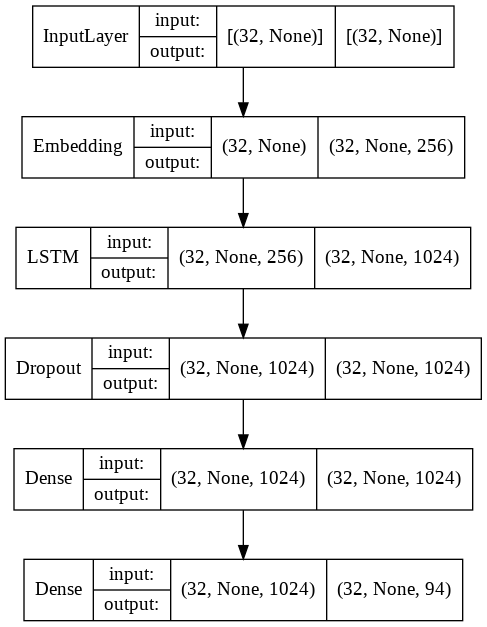

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [ ]:
# Reference Lab 3 RNN
#@title Test configuration with one example

for input_example_batch, target_example_batch in dataset.take(1):
    # Run the batch through the model
    example_batch_predictions = model(input_example_batch)

    # Print output shape
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

    # To get the predictions, sample over the output distribution
    sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
    sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy() 
    
    # Decode the indices to see the text predicted by the (untrained) model
    print("Input: \n", repr("".join(idx2char[input_example_batch[0]])), "\n")
    print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices])))

(32, 100, 94) # (batch_size, sequence_length, vocab_size)
Input: 
 ' the folk flowed in, and ober-cassel\nah could you but enter my castle \n this calico mare both gallop' 

Next Char Predictions: 
 "śé.ps.óëþwôo&yâ|2:pśq—s†uò0 ]*cëîlp4a34à].ê câæ\nô]yßi]*f=z=—2w/:[ôatx0ïó*äq†/w|8ó's5*ħ&üçr{ú9anékëëk"


In [ ]:
#@title Train the model

# default: 50
history = model.fit(dataset, epochs=no_of_epochs, callbacks=[checkpoint_callback])

Epoch 1/50
258/258 [==============================] - 15s 45ms/step - loss: 2.5790 - accuracy: 0.2714
Epoch 2/50
258/258 [==============================] - 12s 45ms/step - loss: 2.0276 - accuracy: 0.3935
Epoch 3/50
258/258 [==============================] - 12s 46ms/step - loss: 1.8480 - accuracy: 0.4378
Epoch 4/50
258/258 [==============================] - 12s 46ms/step - loss: 1.7224 - accuracy: 0.4714
Epoch 5/50
258/258 [==============================] - 12s 46ms/step - loss: 1.6156 - accuracy: 0.5010
Epoch 6/50
258/258 [==============================] - 12s 46ms/step - loss: 1.5152 - accuracy: 0.5305
Epoch 7/50
258/258 [==============================] - 12s 47ms/step - loss: 1.4137 - accuracy: 0.5622
Epoch 8/50
258/258 [==============================] - 12s 47ms/step - loss: 1.3107 - accuracy: 0.5950
Epoch 9/50
258/258 [==============================] - 12s 47ms/step - loss: 1.2078 - accuracy: 0.6279
Epoch 10/50
258/258 [==============================] - 12s 47ms/step - loss: 1.110

Text(0.5, 1.0, 'Training accuracy')

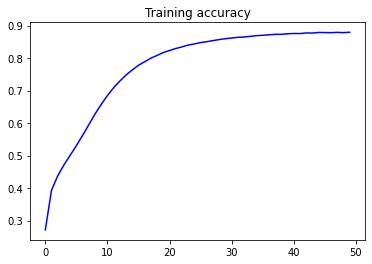

In [ ]:
#@title Model Accuracy
accuracy = history.history['accuracy']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.title('Training accuracy')

Text(0.5, 1.0, 'Training Loss')

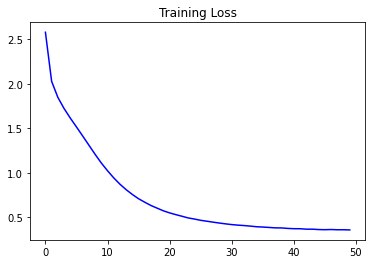

In [ ]:
#@title Model Loss
loss = history.history['loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training accuracy')
plt.title('Training Loss')

In [ ]:
#Reference lab 3
#@title Restore latest checkpoint and build model

batch_size = 1

model = build_model(batch_size=batch_size)
model.load_weights(tf.train.latest_checkpoint("/content/gdrive/" + path))
model.build(tf.TensorShape([batch_size, None]))
print("tensor shape", tf.TensorShape([batch_size, None]))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            24064     
                                                                 
 lstm_1 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dropout_1 (Dropout)         (1, None, 1024)           0         
                                                                 
 dense_2 (Dense)             (1, None, 1024)           1049600   
                                                                 
 dense_3 (Dense)             (1, None, 94)             96350     
                                                                 
Total params: 6,416,990
Trainable params: 6,416,990
Non-trainable params: 0
_________________________________________________________________
tensor shape (1, None)


In [ ]:
#Reference lab 3
#@title Set up text generation function

def generate_text(model, input_text, n_characters_output=300, top_k_sampling = 0,top_p_sampling = 0, temperature = 0):
    # First, vectorize the input text as before
    input_eval = [char2idx[s] for s in input_text]
    input_eval = tf.expand_dims(input_eval, 0)

    # We'll store results in this variable
    text_generated = []

    # Generate the number of characters desired
    model.reset_states()
    for i in range(n_characters_output):
        # Run input through model
        predictions = model(input_eval)

        # Remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        input_eval = tf.expand_dims([predicted_id], 0)

        # Add the predicted character to the output
        text_generated.append(idx2char[predicted_id])

    # Return output
    return (input_text + ''.join(text_generated))

In [ ]:
#@title Generated Text using Top P Sampling (Nucleus Sampling)

input_text = "what is a life"  # @param {type: "string"}
n_characters_output = 300 #@param 
top_p_params = 0.92 #@param {type:"slider", min:0, max:1,step:0.01}
print(generate_text(model, input_text=input_text, n_characters_output=n_characters_output, top_k_sampling = 0,top_p_sampling = top_p_params, temperature = 0))

what is a life had president 
 down the slippery chamel sincers and infinity 
 into the charities
there are men to paint the inscrutable 
 lay that i found a great and very reuses 
 and or a wine with favoring winds
flew up, nor miss'd his high faithfully are so found 
 and all my two strong sit glassed
i have al


In [ ]:
#@title Generated Text using Top K sampling

input_text = "tread softly because you tread on my dreams "  # @param {type: "string"}
n_characters_output = 300 #@param
top_k_params =  7#@param 
print(generate_text(model, input_text=input_text, n_characters_output=n_characters_output, top_k_sampling = top_k_params,top_p_sampling = 0.92, temperature = 0))

tread softly because you tread on my dreams ether blood 
 that strip off all husks
his mind should be dolly 
 and shung the sky, and the strong scaffer 
 of fathers and against the other, sons and saw went more appointment
but works with dawn off the tell men compute 
 me: et nothing forge all smooth 
 to starry heights lift his entreaty
 whe


In [ ]:
#@title Generated Text using Temperature Sampling

input_text = "to be or not to be"  # @param {type: "string"}
n_characters_output = 300 #@param
temperature_params = 1.2 #@param 
print(generate_text(model, input_text=input_text, n_characters_output=n_characters_output, top_k_sampling = 0,top_p_sampling = 0, temperature = temperature_params))

to be or not to be soften 
 what shall i launch my dusky little coracle
when she stood trembling, as the oracle 
 just like a black eye in the church archelance
he that has love there some are so small adding 
 at once his extinct
when fellows and bloody frotten 
 were thronged, and she would lion
he'll come back som


In [ ]:
#@title Try your own Poem

#@markdown Remember to load the pretrained model before running by running all steps except training (Insert step number)

input_text = "what is a house "  # @param {type: "string"}
n_characters_output = 300 #@param

top_k_params = 0 #@param 
top_p_params = 0 #@param {type:"slider", min:0, max:1,step:0.01}
temperature_params = 0 #@param

print(generate_text(model, input_text=input_text, n_characters_output=n_characters_output, top_k_sampling = top_k_params,top_p_sampling = top_p_params, temperature = temperature_params))

what is a house that's firmer 
 i would pity the weight of the cask 
 yet thence his lustful orgies 
 defluxit numerus saturnius, et grave virus
aura aure then, with his smile for soft 
 the story of the tower, who look well defended 
 they say,  in the land of gosh 
 no change, but passive ladder 
 if our engers' 


Links to sources that helped me build the project:

Allison Parrish Experiments:

https://github.com/aparrish/gutenberg-poetry-corpus/blob/master/quick-experiments.ipynb

Text Generation Shakespere by Oleksii Trekhleb:

https://colab.research.google.com/github/trekhleb/machine-learning-experiments/blob/master/experiments/text_generation_shakespeare_rnn/text_generation_shakespeare_rnn.ipynb#scrollTo=ghB-VwLlD-Oz